<a href="https://colab.research.google.com/github/Ali-Shalabi-UPenn/ENGR1050/blob/main/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:73: SyntaxWarning: invalid escape sequence '\e'
<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\e'
<>:74: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-833416994.py:73: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Strain ($\epsilon$, mm/mm)', fontsize=12)
/tmp/ipython-input-833416994.py:74: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Stress ($\sigma$, MPa)', fontsize=12)


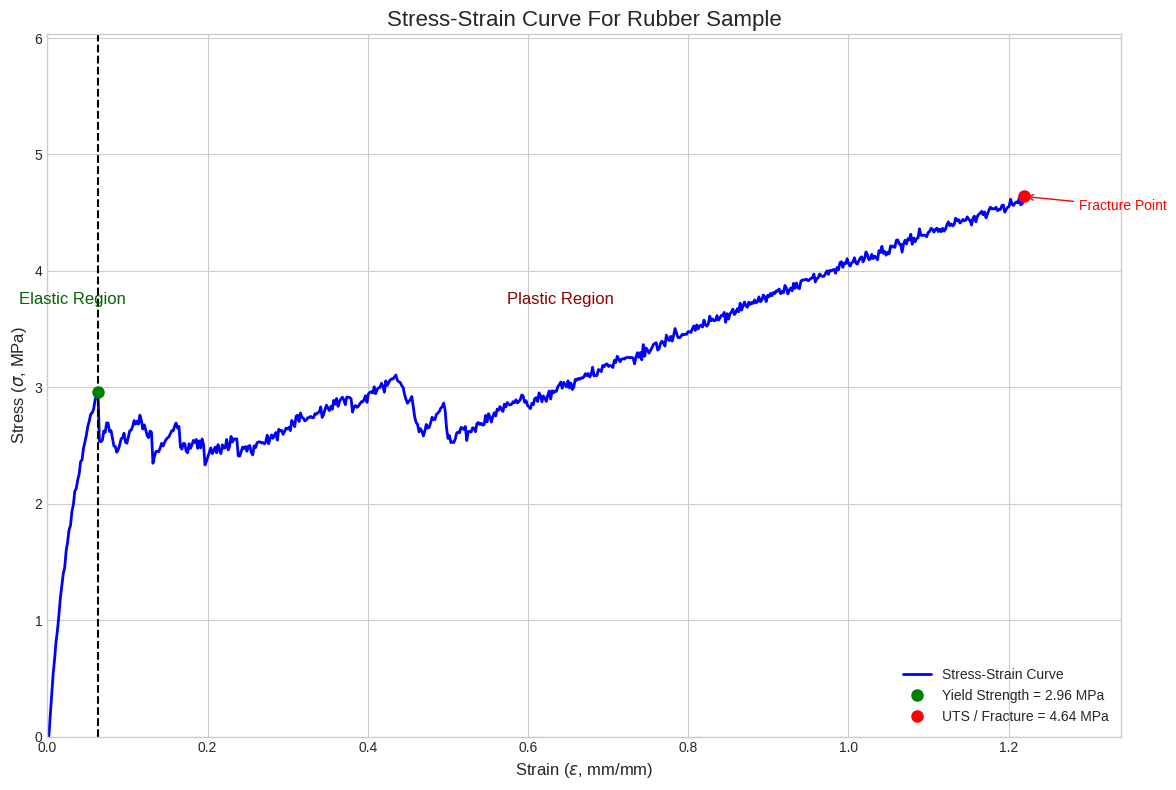

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def analyze_and_plot_tensile_data():

    file_path = 'DAQ- Crosshead, … - (Timed) (1).csv'
    data = pd.read_csv(file_path, skiprows=6)

    displacement_col = 'Crosshead '
    force_col = 'Load '

    displacement = pd.to_numeric(data[displacement_col], errors='coerce').values
    force = pd.to_numeric(data[force_col], errors='coerce').values

    valid_mask = ~np.isnan(displacement) & ~np.isnan(force)
    displacement = displacement[valid_mask]
    force = force[valid_mask]

    if len(force) > 0:
        force = force - force[0]


    # Sample's Dimensions
    initial_gage_length_mm = 110.79
    initial_width_mm = 12.96
    initial_thickness_mm = 1.46

    # Calculations
    initial_area_mm2 = initial_width_mm * initial_thickness_mm
    strain = displacement / initial_gage_length_mm
    stress_mpa = force / initial_area_mm2

    # Truncate Data at UTS
    uts_index = np.argmax(stress_mpa)
    plot_strain = strain[:uts_index + 1]
    plot_stress_mpa = stress_mpa[:uts_index + 1]

    # Material Properties
    yield_strain, yield_strength_mpa = 0.063, 2.96
    uts_mpa, uts_strain = 4.64, plot_strain[-1]

    # Create Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Stress-strain curve
    ax.plot(plot_strain, plot_stress_mpa, label='Stress-Strain Curve', color='blue', linewidth=2)

    # Vertical dashed line for transition
    transition_strain = 0.063
    ax.axvline(x=transition_strain, color='k', linestyle='--', linewidth=1.5)

    # Region labels
    ax.text(transition_strain/2, uts_mpa*0.8, "Elastic Region", ha='center', fontsize=12, color='darkgreen')
    ax.text((transition_strain+uts_strain)/2, uts_mpa*0.8, "Plastic Region", ha='center', fontsize=12, color='darkred')

    # Yield strength marker (green)
    ax.plot(yield_strain, yield_strength_mpa, 'o', color='green', markersize=8, label=f'Yield Strength = {yield_strength_mpa:.2f} MPa')

    # UTS / Fracture point marker (red)
    ax.plot(uts_strain, uts_mpa, 'o', color='red', markersize=8, label=f'UTS / Fracture = {uts_mpa:.2f} MPa')

    # Annotate fracture point (moved to the right for clarity)
    ax.annotate("Fracture Point",
        (uts_strain, uts_mpa),
        textcoords="offset points", xytext=(40, -10),
        ha='left', color='red',
        arrowprops=dict(arrowstyle="->", color='red'))


    ax.set_title('Stress-Strain Curve For Rubber Sample', fontsize=16)
    ax.set_xlabel('Strain ($\epsilon$, mm/mm)', fontsize=12)
    ax.set_ylabel('Stress ($\sigma$, MPa)', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True)

    ax.set_xlim(left=0, right=uts_strain * 1.1)
    ax.set_ylim(bottom=0, top=uts_mpa * 1.3)
    plt.tight_layout()
    plt.show()

# Plot
analyze_and_plot_tensile_data()


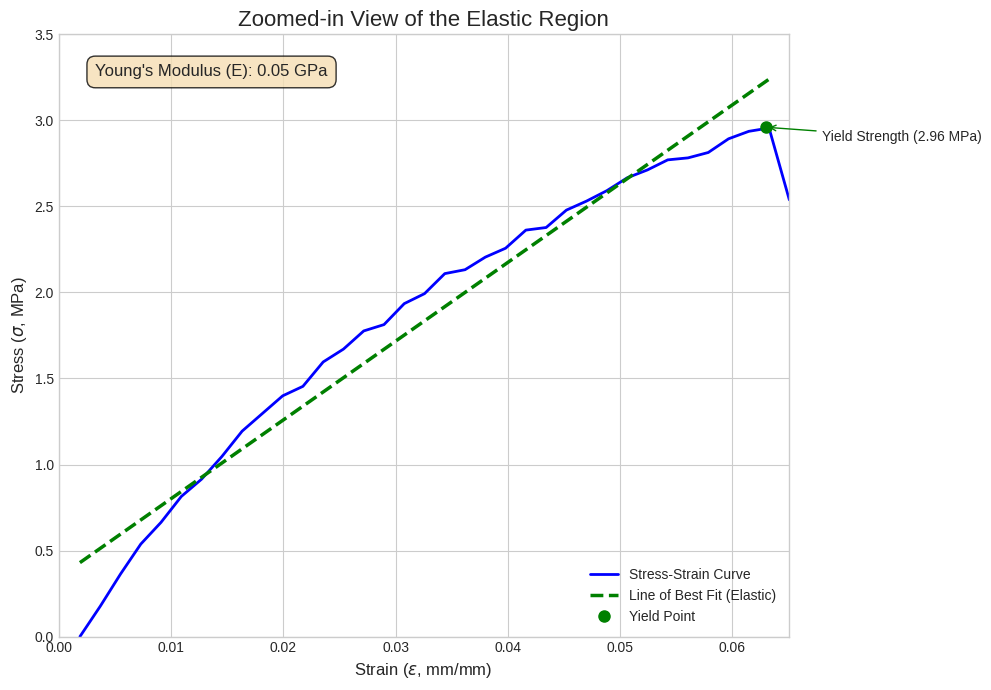

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_zoomed_elastic_region():
    file_path = 'DAQ- Crosshead, … - (Timed) (1).csv'
    data = pd.read_csv(file_path, skiprows=6)

    # Data Processing and Calculations
    displacement = pd.to_numeric(data['Crosshead '], errors='coerce').dropna().values
    force = pd.to_numeric(data['Load '], errors='coerce').dropna().values
    force = force - force[0]

    initial_gage_length_mm = 110.79
    initial_width_mm = 12.96
    initial_thickness_mm = 1.46
    initial_area_mm2 = initial_width_mm * initial_thickness_mm

    strain = displacement / initial_gage_length_mm
    stress_mpa = force / initial_area_mm2

    # Elastic region
    elastic_mask = (strain > 0) & (strain <= 0.065)
    elastic_strain = strain[elastic_mask]
    elastic_stress = stress_mpa[elastic_mask]

    slope, intercept = (0, 0)
    youngs_modulus_gpa = 0
    if len(elastic_strain) > 1:
        slope, intercept = np.polyfit(elastic_strain, elastic_stress, 1)
        youngs_modulus_gpa = slope / 1000

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(strain, stress_mpa, label='Stress-Strain Curve', color='blue', linewidth=2)

    if slope > 0:
        best_fit_line = slope * elastic_strain + intercept
        ax.plot(elastic_strain, best_fit_line, 'g--', label='Line of Best Fit (Elastic)', linewidth=2.5)

        # Young’s modulus box
        ax.text(0.05, 0.95, f"Young's Modulus (E): {youngs_modulus_gpa:.2f} GPa",
                transform=ax.transAxes, fontsize=12, va='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Yield Strength
    yield_strain, yield_strength_mpa = 0.063, 2.96
    ax.plot(yield_strain, yield_strength_mpa, 'go', markersize=8, label='Yield Point')
    ax.annotate(f'Yield Strength ({yield_strength_mpa:.2f} MPa)',
                (yield_strain, yield_strength_mpa),
                textcoords="offset points", xytext=(40, -10),
                arrowprops=dict(arrowstyle="->", color='green'))

    # Labels & Limits
    ax.set_title('Zoomed-in View of the Elastic Region', fontsize=16)
    ax.set_xlabel(r'Strain ($\epsilon$, mm/mm)', fontsize=12)   # raw string for LaTeX
    ax.set_ylabel(r'Stress ($\sigma$, MPa)', fontsize=12)       # raw string for LaTeX
    ax.legend()
    ax.grid(True)

    ax.set_xlim(0, 0.065)
    ax.set_ylim(0, 3.5)

    plt.tight_layout()
    plt.show()

# Run function
plot_zoomed_elastic_region()


✅ File loaded successfully for zoomed second region.


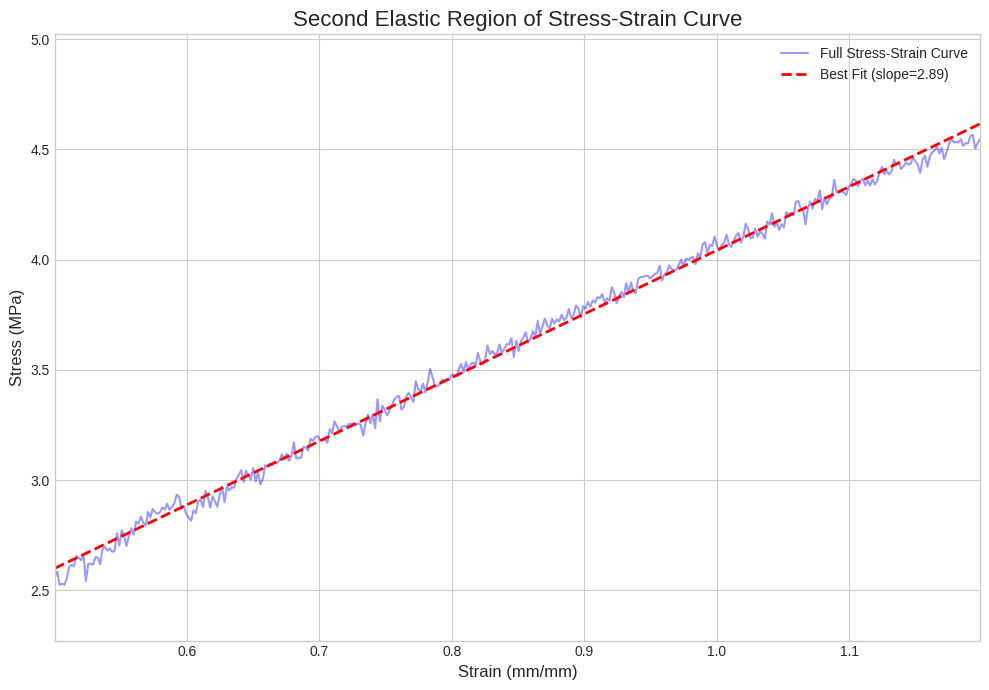

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_second_linear_region():
    """
    Loads tensile data, isolates the second linear portion of the
    stress-strain curve, and creates a zoomed-in plot with best-fit line.
    """
    # --- Load Data ---
    file_path = 'DAQ- Crosshead, … - (Timed) (1).csv'
    try:
        data = pd.read_csv(file_path, skiprows=6)
        print("✅ File loaded successfully for zoomed second region.")
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found.")
        return

    # --- Extract Columns ---
    displacement = pd.to_numeric(data['Crosshead '], errors='coerce').dropna().values
    force = pd.to_numeric(data['Load '], errors='coerce').dropna().values
    force = force - force[0]

    # --- Sample Dimensions ---
    initial_gage_length_mm = 110.79
    initial_width_mm = 12.96
    initial_thickness_mm = 1.46
    initial_area_mm2 = initial_width_mm * initial_thickness_mm

    # --- Stress & Strain ---
    strain = displacement / initial_gage_length_mm
    stress_mpa = force / initial_area_mm2

    # --- Select Second Linear Region ---
    # 👇 Adjust these bounds depending on where your 2nd slope appears
    second_region_mask = (strain > 0.5) & (strain < 1.2)
    second_strain = strain[second_region_mask]
    second_stress = stress_mpa[second_region_mask]

    # --- Best Fit Line ---
    slope, intercept = np.polyfit(second_strain, second_stress, 1)
    best_fit_line = slope * second_strain + intercept

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(strain, stress_mpa, color='blue', alpha=0.4, label='Full Stress-Strain Curve')
    ax.plot(second_strain, best_fit_line, 'r--', linewidth=2, label=f'Best Fit (slope={slope:.2f})')

    ax.set_title('Second Elastic Region of Stress-Strain Curve', fontsize=16)
    ax.set_xlabel('Strain (mm/mm)', fontsize=12)
    ax.set_ylabel('Stress (MPa)', fontsize=12)
    ax.legend()
    ax.grid(True)

    # 👇 Zoom into just the second region
    ax.set_xlim(second_strain.min(), second_strain.max())
    ax.set_ylim(second_stress.min() * 0.9, second_stress.max() * 1.1)

    plt.tight_layout()
    plt.show()

# --- Run ---
plot_second_linear_region()
